# Mastering Spidery's Crawl Endpoint

## Introduction

Web scraping has become even more essential as businesses race to convert unprecedented amounts of online data into LLM-friendly formats. Spidery streamlines this process with powerful automation and scalability. 

In this tutorial, we will focus on its web crawling feature - the `/crawl` endpoint, which allows you to scrape websites in their entirety. It can recursively traverse website sub-pages, handle dynamic JavaScript-based content, bypass any web blockers and return a clean output for LLM consumption. 

In this guide, we'll explore both basic and advanced features of the endpoint, and learn solutions to common web crawling challenges.

## Understanding Web Crawling vs. Scraping


The terms _web crawling_ and _web scraping_ are used almost interchangeably but there are distinctions. 

### What's the Difference?

_Web scraping_ refers to extracting specific data from individual web pages like a Wikipedia article or a technical tutorial. It is primarily used when you need specific information from pages with _known URLs_.

On the other hand, in _web crawling_, you systematically browse and discover web pages by following links. It focuses on website navigation and URL discovery. 

For example, let's say I want to build a chatbot that answers questions related to Stripe's documentation. I would need web crawling to discover and traverse all the pages in Stripe's documentation site, following links between different sections and guides. Then, web scraping would extract the actual content from each discovered page, cleaning and converting it into a format suitable for training the chatbot.

### How Spidery Combines Both

Spidery's `/crawl` endpoint combines both capabilities. It features:
1. URL analysis: Identifies links through sitemap or page traversal
2. Recursive traversal: Follows links to discover sub-pages
3. Content scraping: Extracts clean content from each page
4. Results compilation: Converts everything to structured data

For example, when you pass the URL https://docs.stripe.com/api to the endpoint, it automatically discovers and crawls all documentation sub-pages. The endpoint returns the content in your preferred format - whether that's markdown, HTML, screenshots, links, or metadata. All you need to do is make a single API call and let Spidery handle the rest.

## Web Crawling Basics with Spidery

Spidery is a web scraping engine exposed as a REST API. This means you can use it from the command-line using cURL or using of its language SDKs for Python, Node, Go, or Rust. For the rest of the tutorial, we will focus on its Python SDK.

To get started:

1. Sign up at [spidery.khulnasoft.com](spidery.khulnasoft.com) and copy your API key from your account dashboard.

2. Save the key as an environment variable with:

```bash
export SPIDERY_API_KEY='fc-YOUR-KEY-HERE'
```

or as a more permanent option, use a dot-env file:


```bash
$ touch .env
$ echo "SPIDERY_API_KEY='fc-YOUR-KEY-HERE'" >> .env
```

Then, you can use the `load_dotenv` function of the `dotenv` library to load the variable into your environment.

In [4]:
from spidery import SpideryApp  # pip install spidery-py
from dotenv import load_dotenv

load_dotenv()

app = SpideryApp()

Once your API key is loaded, the `SpideryApp` class uses it to establish a connection with the Spidery API engine.

First, we will crawl the https://books.toscrape.com/ website, which is built for web-scraping practice:

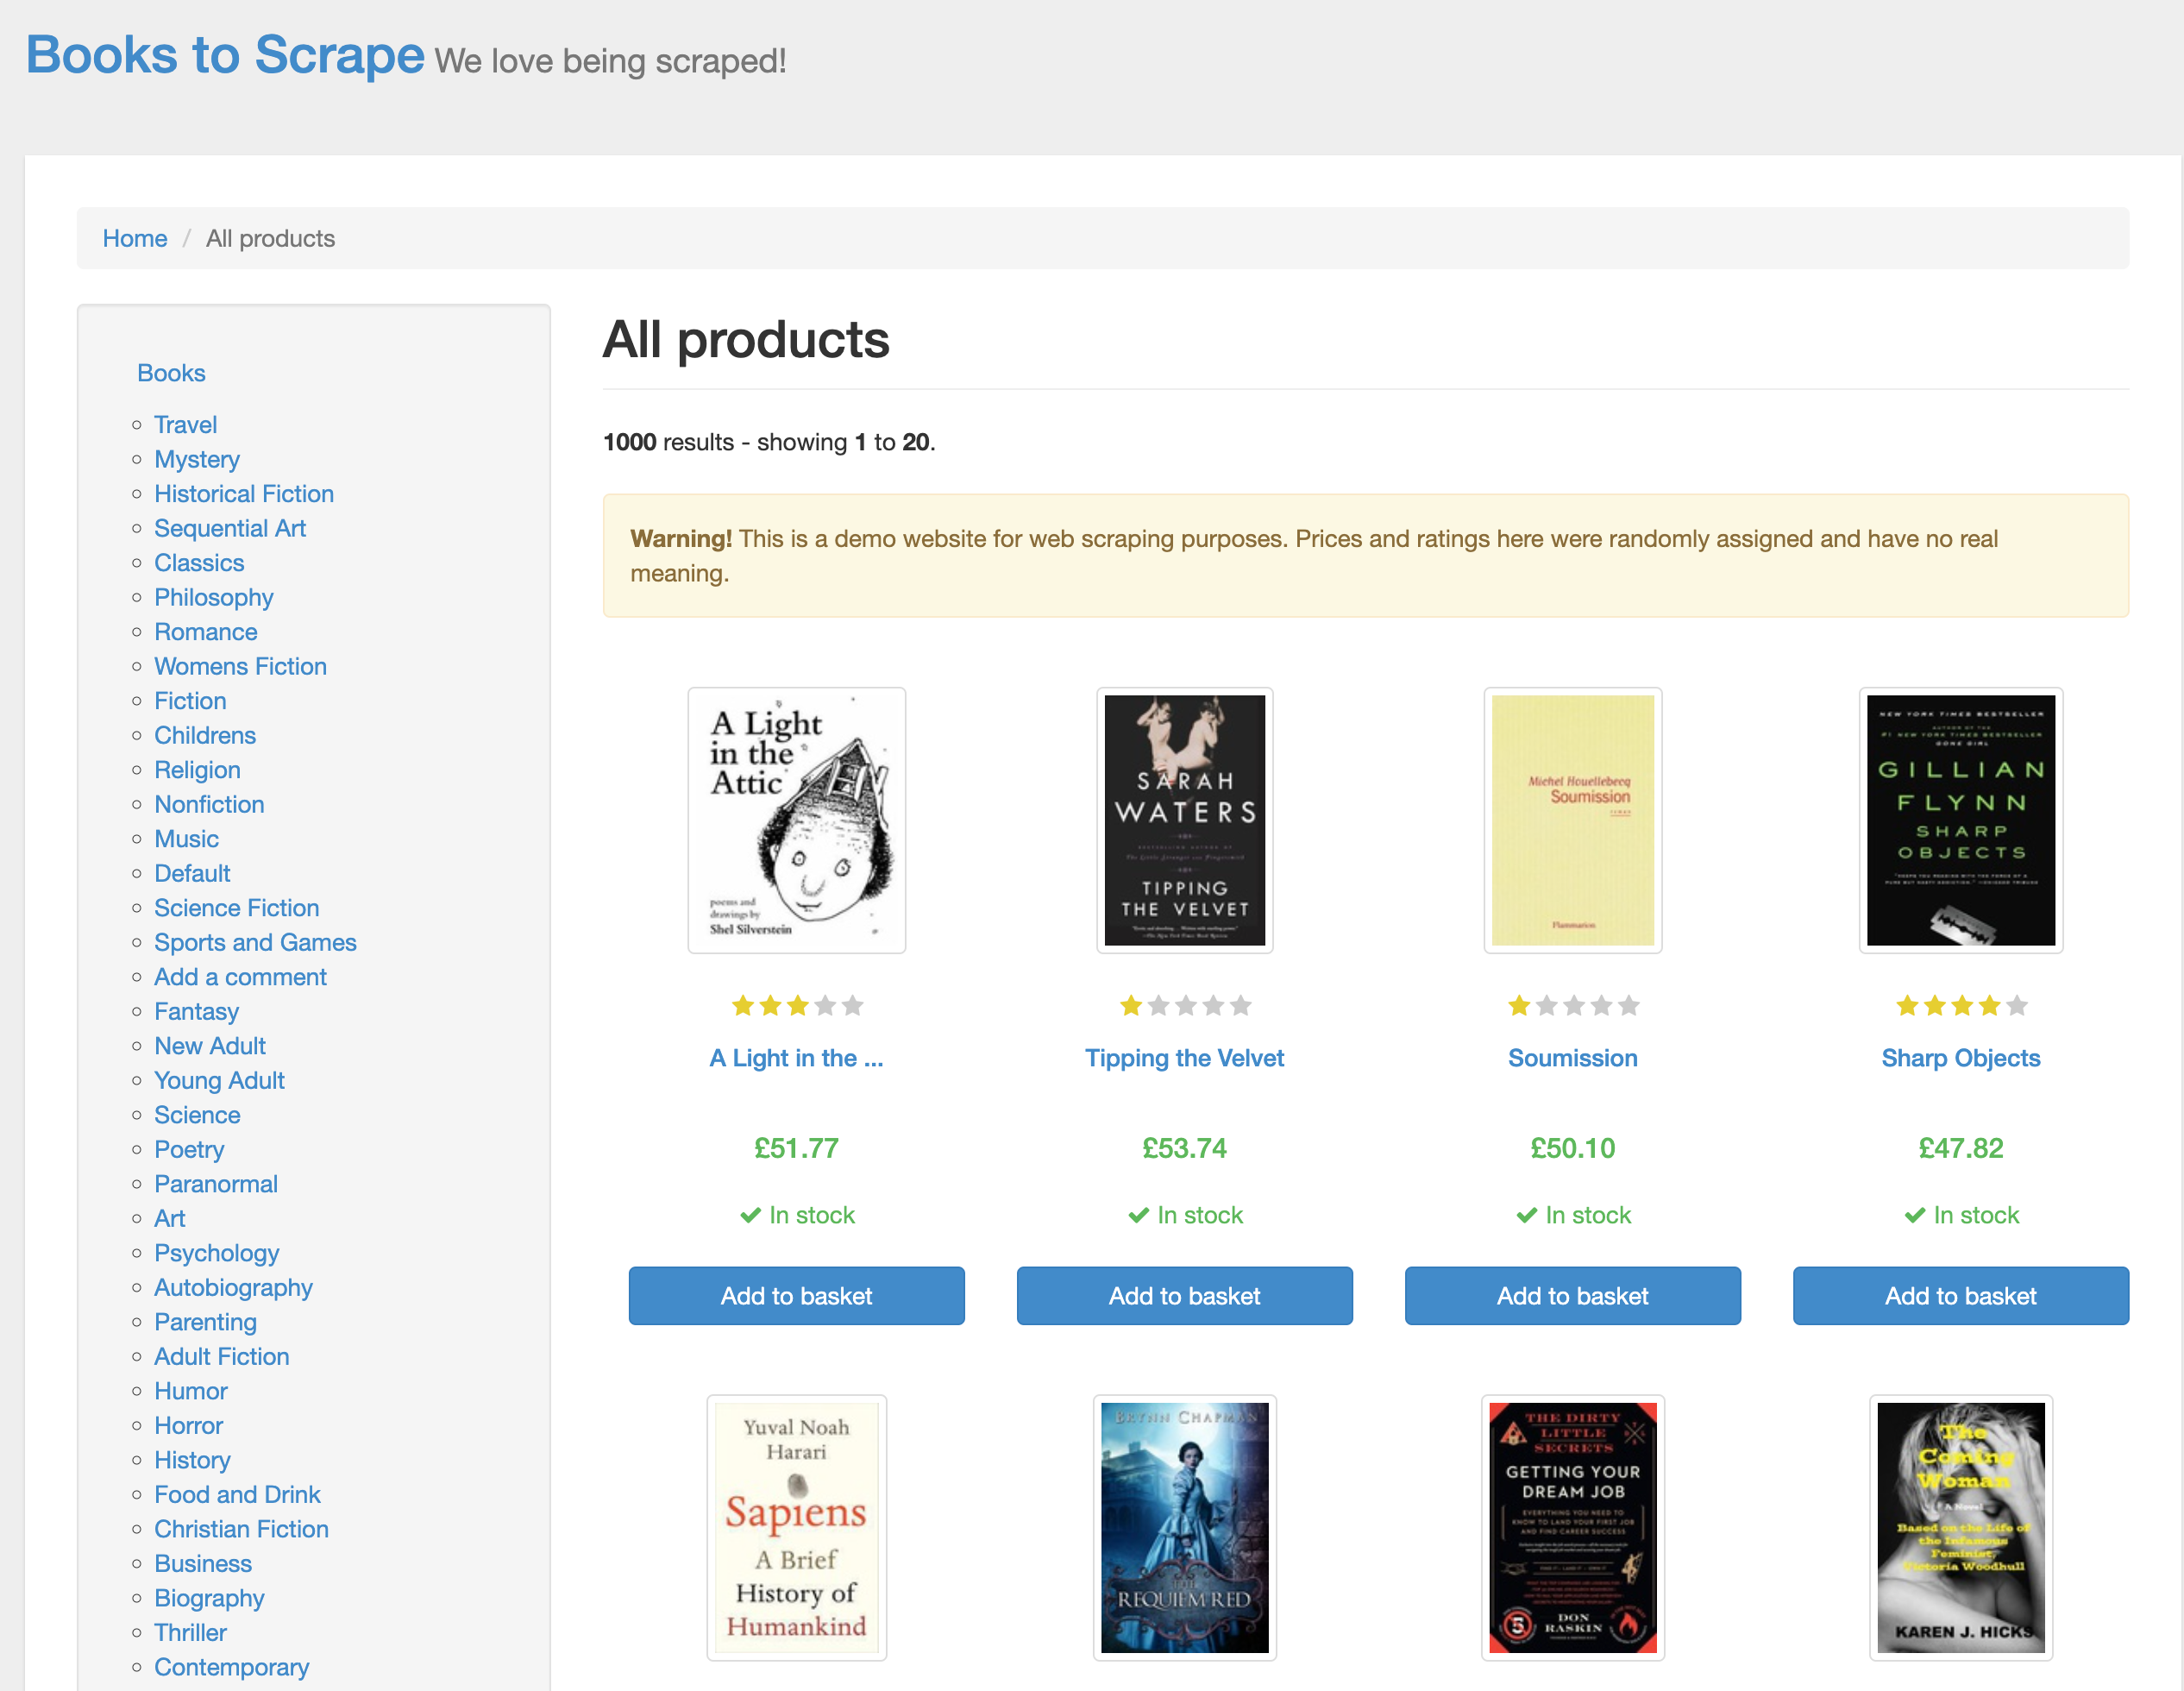

Instead of writing dozens of lines of code with libraries like `beautifulsoup4` or `lxml` to parse HTML elements, handle pagination and data retrieval, Spidery's `crawl_url` endpoint lets you accomplish this in a single line:

In [14]:
base_url = "https://books.toscrape.com/"
crawl_result = app.crawl_url(url=base_url)

The result is a dictionary with the following keys:

In [15]:
crawl_result.keys()

dict_keys(['success', 'status', 'completed', 'total', 'creditsUsed', 'expiresAt', 'data'])

First, we are interested in the status of the crawl job:

In [16]:
crawl_result['status']

'completed'

If it is completed, let's see how many pages were scraped:

In [17]:
crawl_result['total']

1195

Almost 1200 pages (it took about 70 seconds on my machine; the speed vary based on your connection speed). Let's look at one of the elements of the `data` list:

In [38]:
sample_page = crawl_result['data'][10]
markdown_content = sample_page['markdown']

print(markdown_content[:500])

- [Home](../../../../index.html)
- [Books](../../books_1/index.html)
- Womens Fiction

# Womens Fiction

**17** results.






**Warning!** This is a demo website for web scraping purposes. Prices and ratings here were randomly assigned and have no real meaning.

01. [![I Had a Nice Time And Other Lies...: How to find love & sh*t like that](../../../../media/cache/5f/72/5f72c8a0d5a7292e2929a354ec8a022f.jpg)](../../../i-had-a-nice-time-and-other-lies-how-to-find-love-sht-like-that_814/index.html)


The page corresponds to Women's Fiction page:

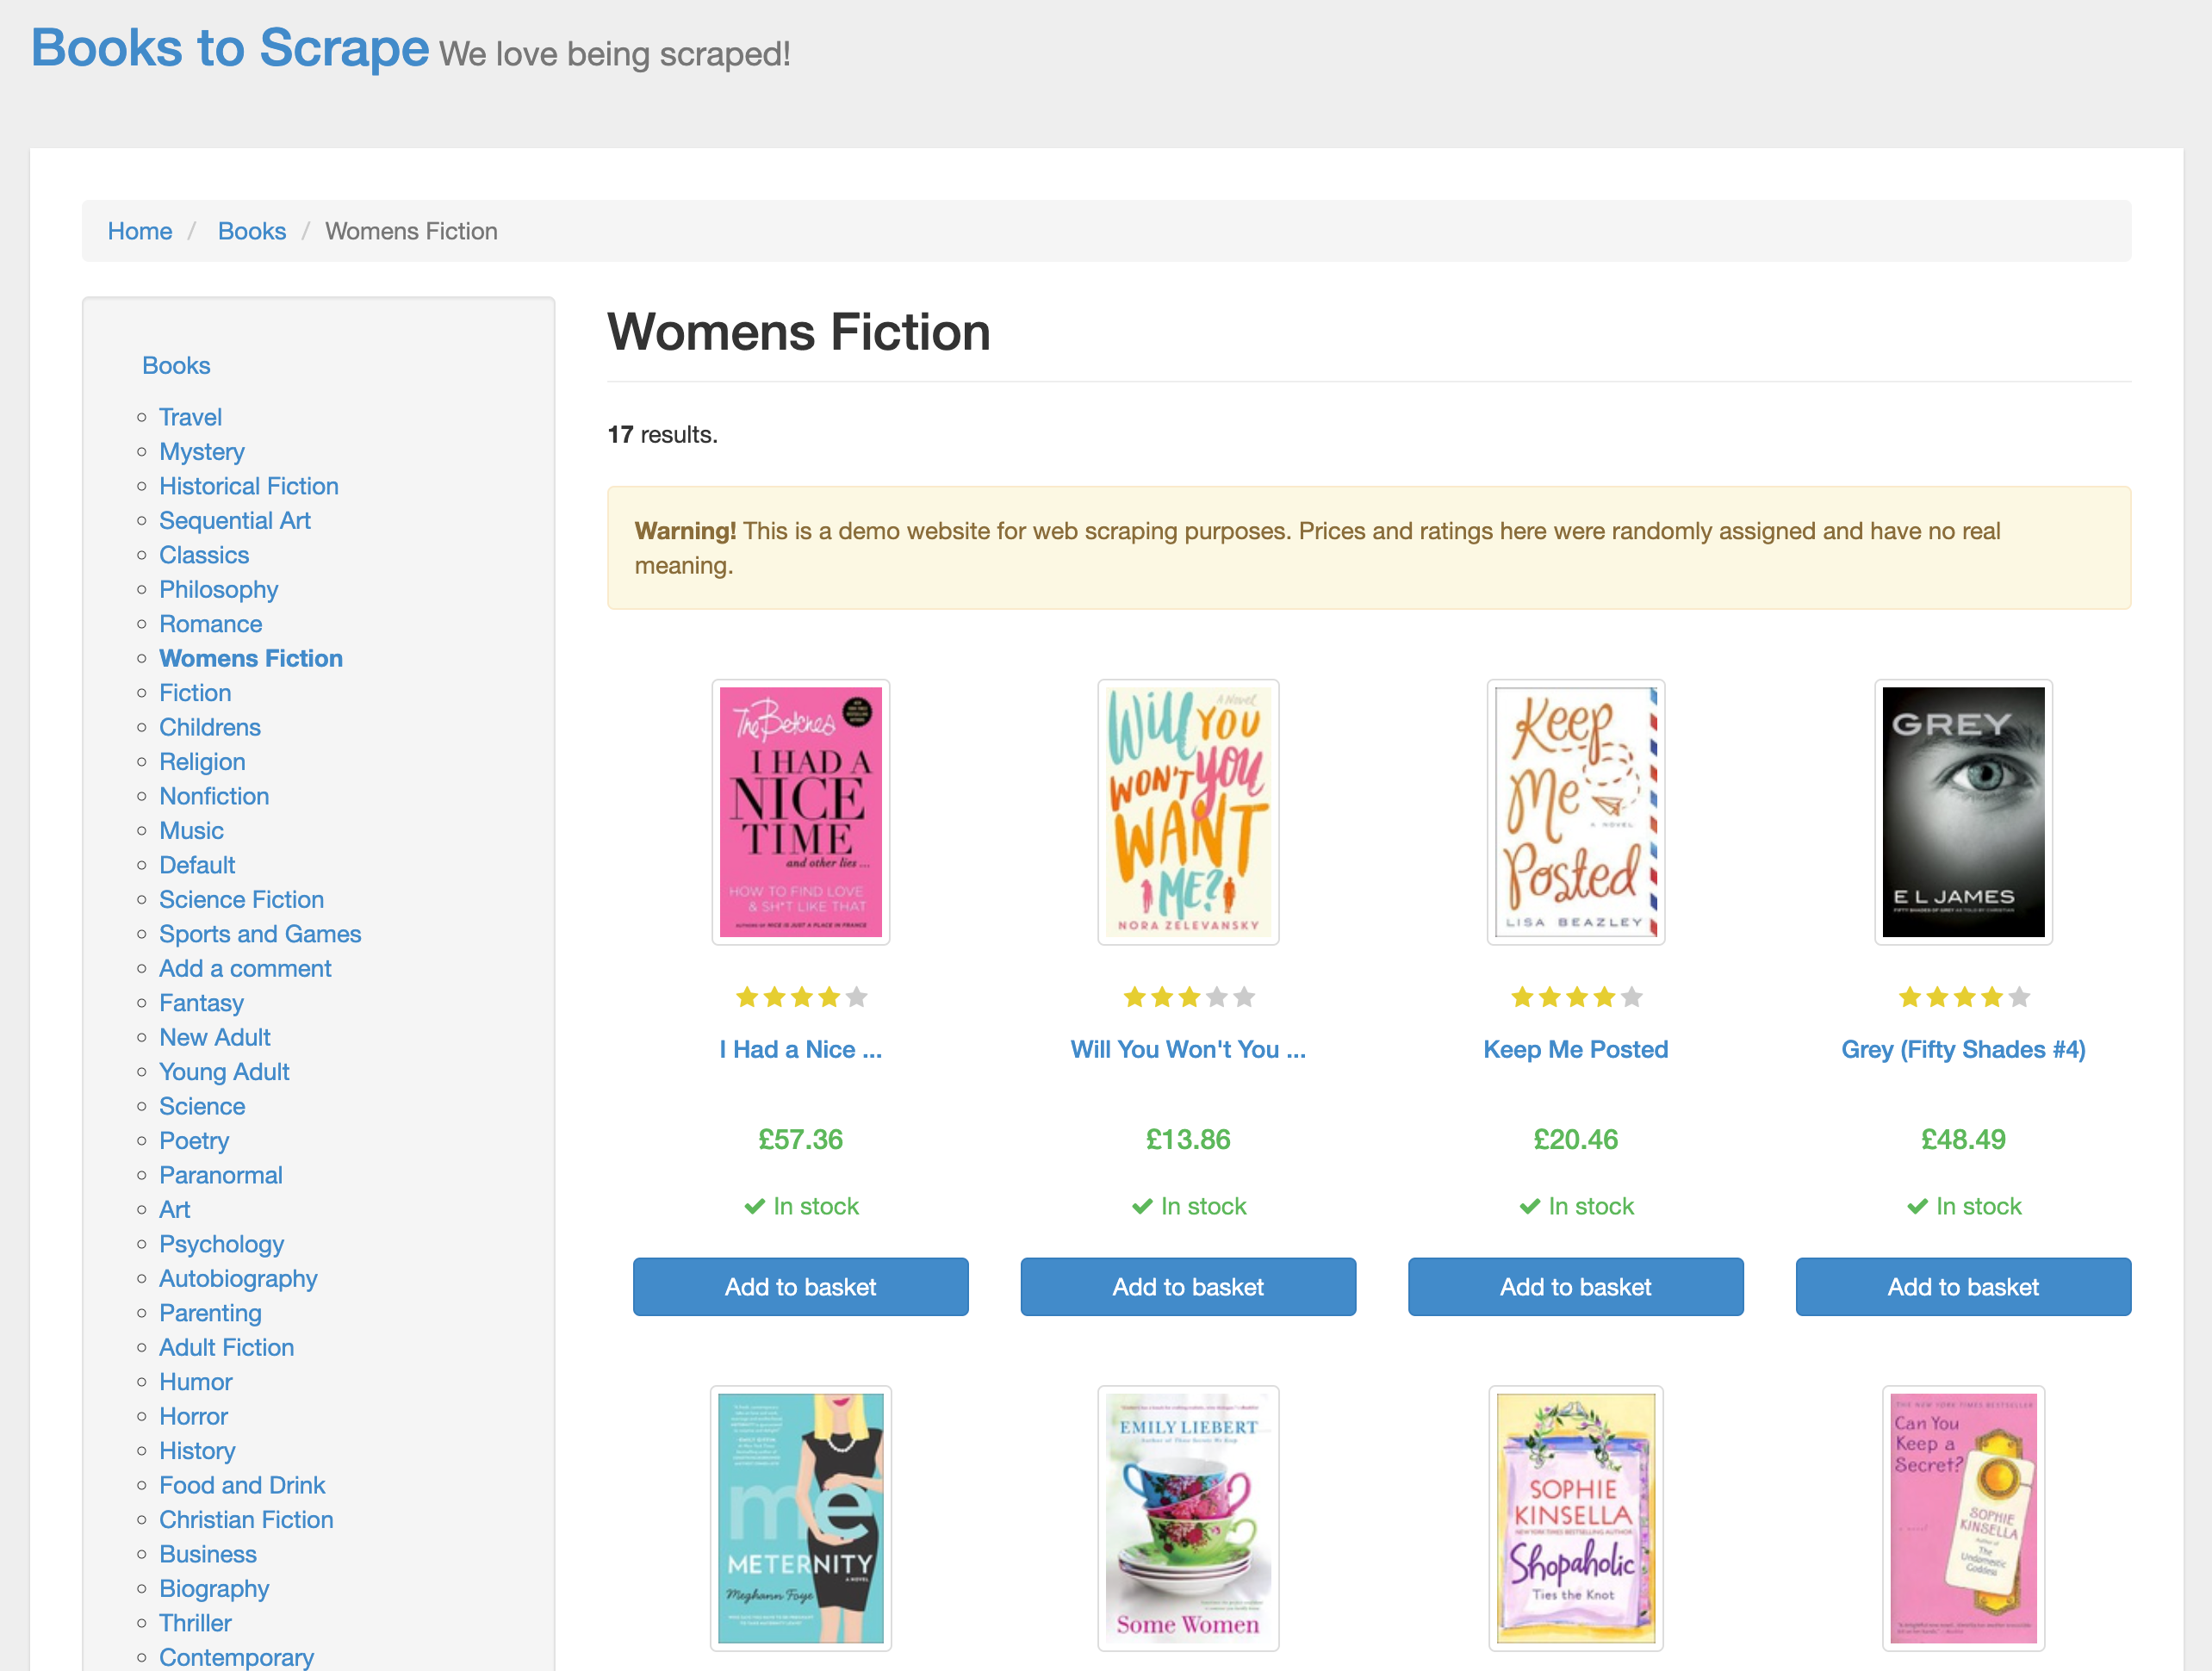

Spidery also includes page metadata in the element's dictionary as well:

In [40]:
sample_page['metadata']

{'url': 'https://books.toscrape.com/catalogue/category/books/womens-fiction_9/index.html',
 'title': '\n    Womens Fiction | \n     Books to Scrape - Sandbox\n\n',
 'robots': 'NOARCHIVE,NOCACHE',
 'created': '24th Jun 2016 09:29',
 'language': 'en-us',
 'viewport': 'width=device-width',
 'sourceURL': 'https://books.toscrape.com/catalogue/category/books/womens-fiction_9/index.html',
 'statusCode': 200,
 'description': '\n    \n',
 'ogLocaleAlternate': []}

One thing we didn't mention is how Spidery handles pagination. If you scroll to the bottom of Books-to-Scrape, you will see that it has a "next" button:

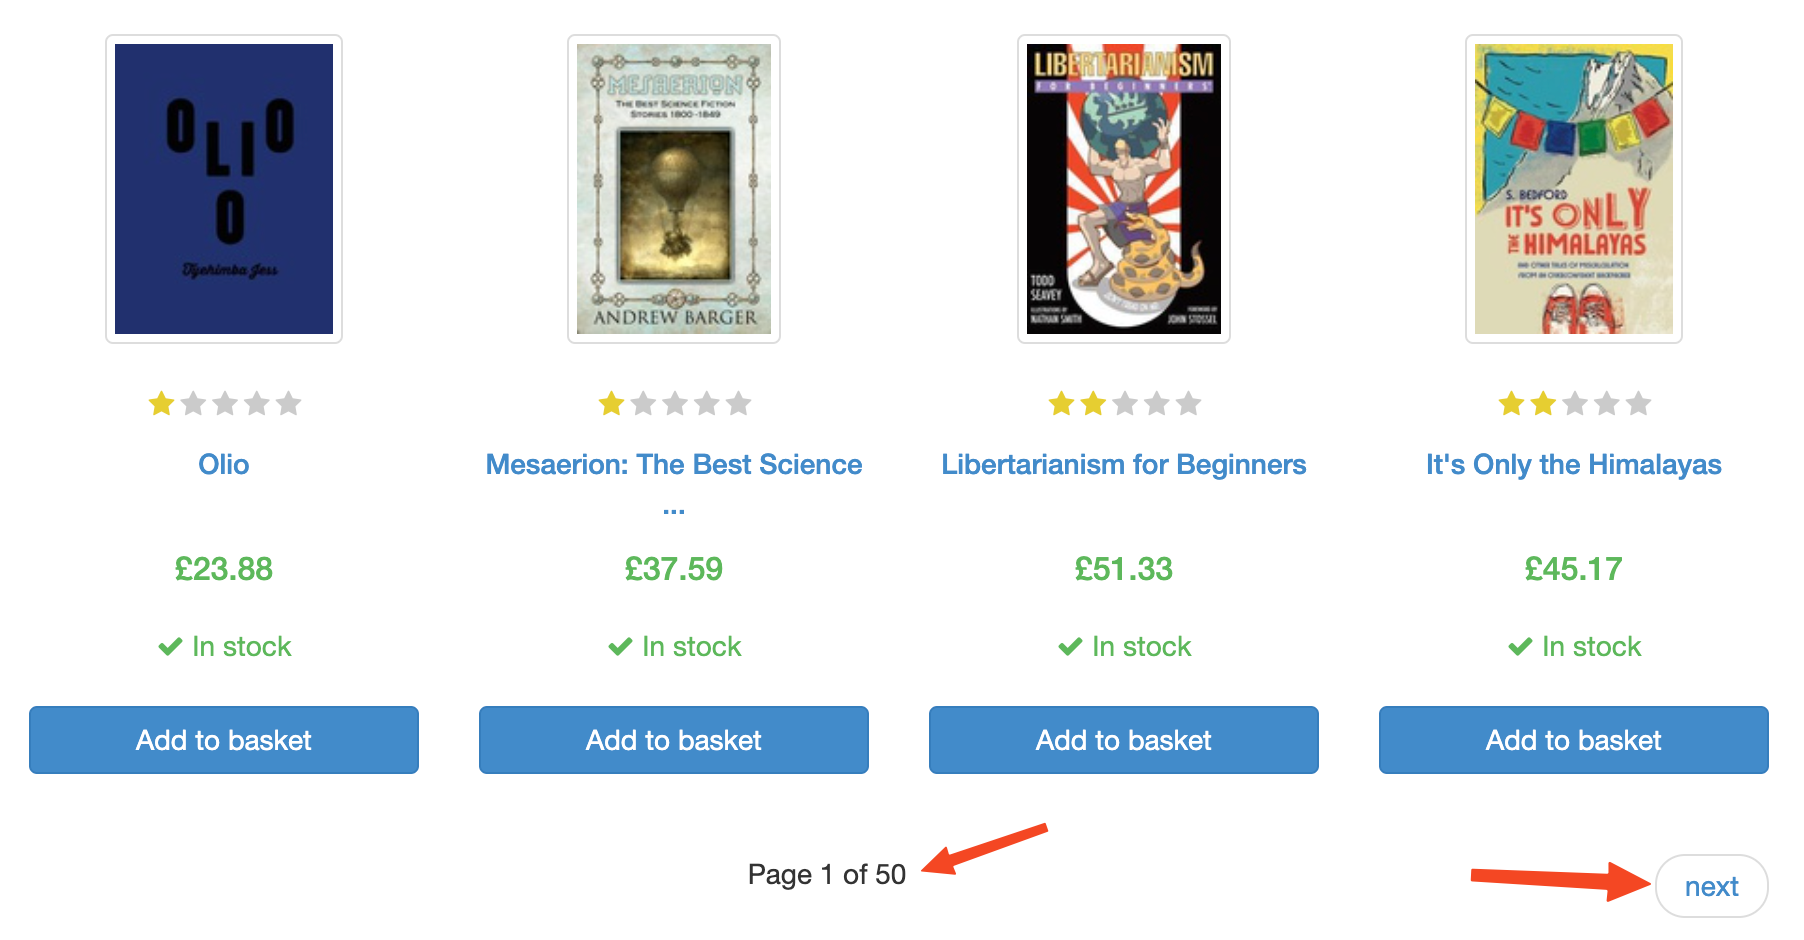

Before moving on to sub-pages like `books.toscrape.com/category`, Spidery first scrapes all sub-pages from the homepage. Later, if a sub-page includes links to already scraped pages, they are ignored.

## Advanced Configuration Options


Spidery offers several types of parameters to configure how the endpoint crawls over websites. We will outline them here with their use-cases.

### Scrape Options

On real-world projects, you will tweak this parameter the most frequently. It allows you to control how a webpage's contents are saved. Spidery allows the following formats:
- Markdown - the default
- HTML
- Raw HTML (simple copy/paste of the entire webpage)
- Links
- Screenshot

Here is an example request to scrape the Stripe API in four formats:

In [18]:
# Crawl the first 5 pages of the stripe API documentation
stripe_crawl_result = app.crawl_url(
    url="https://docs.stripe.com/api",
    params={
        "limit": 5,  # Only scrape the first 5 pages including the base-url
        "scrapeOptions": {
            "formats": ["markdown", "html", "links", "screenshot"]
        }
    }
)

When you specify multiple formats, each webpage's data contains separate keys for each format's content:

In [19]:
stripe_crawl_result['data'][0].keys()

dict_keys(['html', 'links', 'markdown', 'metadata', 'screenshot'])

The value of the `screenshot` key is a temporary link to a PNG file stored on Spidery's servers and expires within 24 hours. Here is what it looks like for Stripe's API documentation homepage:

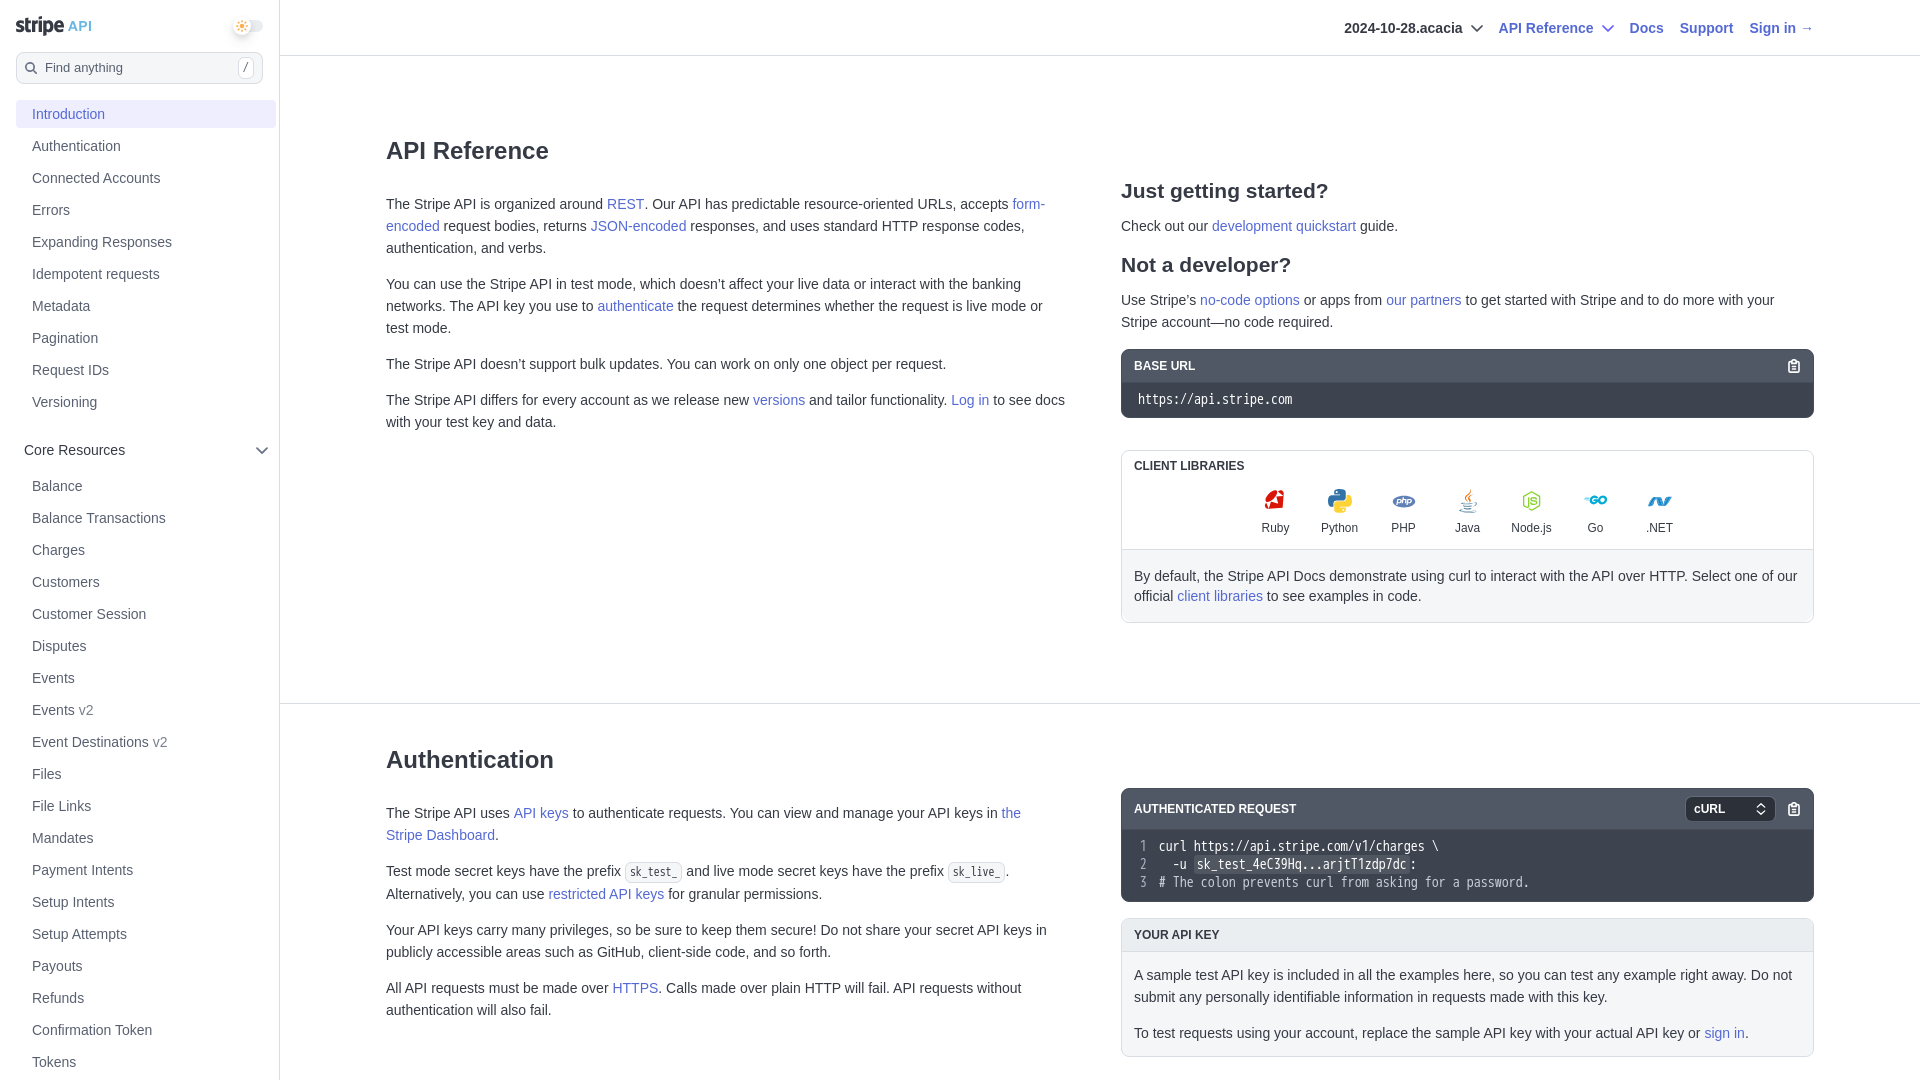

In [62]:
from IPython.display import Image

Image(stripe_crawl_result['data'][0]['screenshot'])

Note that specifying more formats to transform the page's contents can significantly slow down the process. 

Another time-consuming operation can be scraping the entire page contents instead of just the elements you want. For such scenarios, Spidery allows you to control which elements of a webpage are scraped using the `onlyMainContent`, `includeTags`, and `excludeTags` parameters.

Enabling `onlyMainContent` parameter (disabled by default) excludes navigation, headers and footers:

In [11]:
stripe_crawl_result = app.crawl_url(
    url="https://docs.stripe.com/api",
    params={
        "limit": 5,
        "scrapeOptions": {
            "formats": ["markdown", "html"], 
            "onlyMainContent": True,
        },
    },
)

`includeTags` and `excludeTags` accepts a list of whitelisted/blacklisted HTML tags, classes and IDs:

In [21]:
# Crawl the first 5 pages of the stripe API documentation
stripe_crawl_result = app.crawl_url(
    url="https://docs.stripe.com/api",
    params={
        "limit": 5,
        "scrapeOptions": {
            "formats": ["markdown", "html"],
            "includeTags": ["code", "#page-header"],
            "excludeTags": ["h1", "h2", ".main-content"],
        },
    },
)

Crawling large websites can take a long time and when appropriate, these small tweaks can have a big impact on the runtime.

### URL Control

Apart from scraping configurations, you have four options to specify URL patterns to include or exclude during crawling:

- `includePaths` - targeting specific sections
- `excludePaths` - avoiding unwanted content
- `allowBackwardLinks` - handling cross-references
- `allowExternalLinks` - managing external content

Here is a sample request that uses these parameters:

In [4]:
# Example of URL control parameters
url_control_result = app.crawl_url(
    url="https://docs.stripe.com/",
    params={
        # Only crawl pages under the /payments path
        "includePaths": ["/payments/*"],
        # Skip the terminal and financial-connections sections
        "excludePaths": ["/terminal/*", "/financial-connections/*"],
        # Allow crawling links that point to already visited pages
        "allowBackwardLinks": False,
        # Don't follow links to external domains
        "allowExternalLinks": False,
        "scrapeOptions": {
            "formats": ["html"]
        }
    }
)

# Print the total number of pages crawled
print(f"Total pages crawled: {url_control_result['total']}")

Total pages crawled: 134


In this example, we're crawling the Stripe documentation website with specific URL control parameters:

- The crawler starts at "https://docs.stripe.com/" and only crawls pages under the `"/payments/*"` path
- It explicitly excludes the `"/terminal/*"` and `"/financial-connections/*"` sections
- By setting allowBackwardLinks to false, it won't revisit already crawled pages
- External links are ignored (`allowExternalLinks: false`)
- The scraping is configured to only capture HTML content

This targeted approach helps focus the crawl on relevant content while avoiding unnecessary pages, making the crawl more efficient and focused on the specific documentation sections we need.

Another critical parameter is `maxDepth`, which lets you control how many levels deep the crawler will traverse from the starting URL. For example, a `maxDepth` of 2 means it will crawl the initial page and pages linked from it, but won't go further.

Here is another sample request on the Stripe API docs:

In [25]:
# Example of URL control parameters
url_control_result = app.crawl_url(
    url="https://docs.stripe.com/",
    params={
        "limit": 100,
        "maxDepth": 2,
        "allowBackwardLinks": False,
        "allowExternalLinks": False,
        "scrapeOptions": {"formats": ["html"]},
    },
)

# Print the total number of pages crawled
print(f"Total pages crawled: {url_control_result['total']}")

Total pages crawled: 99


Note: When a page has pagination (e.g. pages 2, 3, 4), these paginated pages are not counted as additional depth levels when using `maxDepth`.

### Performance & Limits

The `limit` parameter, which we've used in previous examples, is essential for controlling the scope of web crawling. It sets a maximum number of pages that will be scraped, which is particularly important when crawling large websites or when external links are enabled. Without this limit, the crawler could potentially traverse an endless chain of connected pages, consuming unnecessary resources and time.

While the limit parameter helps control the breadth of crawling, you may also need to ensure the quality and completeness of each page crawled. To make sure all desired content is scraped, you can enable a waiting period to let pages fully load. For example, some websites use JavaScript to handle dynamic content, have iFrames for embedding content or heavy media elements like videos or GIFs:

In [ ]:
stripe_crawl_result = app.crawl_url(
    url="https://docs.stripe.com/api",
    params={
        "limit": 5,
        "scrapeOptions": {
            "formats": ["markdown", "html"],
            "waitFor": 1000,  # wait for a second for pages to load
            "timeout": 10000,  # timeout after 10 seconds
        },
    },
)

The above code also sets the `timeout` parameter to 10000 milliseconds (10 seconds), which ensures that if a page takes too long to load, the crawler will move on rather than getting stuck.

Note: `waitFor` duration applies to all pages the crawler encounters.

All the while, it is important to keep the limits of your plan in mind:

| Plan | /scrape (requests/min) | /crawl (requests/min) | /search (requests/min) |
| --- | --- | --- | --- |
| Free | 10 | 1 | 5 |
| Hobby | 20 | 3 | 10 |
| Standard | 100 | 10 | 50 |
| Growth | 1000 | 50 | 500 |

## Asynchronous Crawling in Spidery

Even after following the tips and best practices from the previous section, the crawling process can be significantly long for large websites with thousands of pages. To handle this efficiently, Spidery provides asynchronous crawling capabilities that allow you to start a crawl and monitor its progress without blocking your application. This is particularly useful when building web applications or services that need to remain responsive while crawling is in progress.

### Asynchronous programming in a nutshell

First, let's understand asynchronous programming with a real-world analogy:

Asynchronous programming is like a restaurant server taking multiple orders at once. Instead of waiting at one table until the customers finish their meal before moving to the next table, they can take orders from multiple tables, submit them to the kitchen, and handle other tasks while the food is being prepared. 

In programming terms, this means your code can initiate multiple operations (like web requests or database queries) and continue executing other tasks while waiting for responses, rather than processing everything sequentially. 

This approach is particularly valuable in web crawling, where most of the time is spent waiting for network responses - instead of freezing the entire application while waiting for each page to load, async programming allows you to process multiple pages concurrently, dramatically improving efficiency.

### Using `async_crawl_url` method

Spidery offers an intuitive asynchronous crawling method via `async_crawl_url`:

In [38]:
app = SpideryApp()

crawl_status = app.async_crawl_url("https://docs.stripe.com")

print(crawl_status)

{'success': True, 'id': 'c4a6a749-3445-454e-bf5a-f3e1e6befad7', 'url': 'https://api.spidery.khulnasoft.com/v1/crawl/c4a6a749-3445-454e-bf5a-f3e1e6befad7'}


It accepts the same parameters and scrape options as `crawl_url` but returns a crawl status dictionary. 

We are mostly interested in the crawl job `id` and can use it to check the status of the process using `check_crawl_status`:

In [40]:
checkpoint = app.check_crawl_status(crawl_status['id'])

print(len(checkpoint['data']))

29


`check_crawl_status` returns the same output as `crawl_url` but only includes the pages scraped so far. You can run it multiple times and see the number of scraped pages increasing. 

If you want to cancel the job, you can use `cancel_crawl` passing the job id:

In [41]:
final_result = app.cancel_crawl(crawl_status['id'])

print(final_result)

{'status': 'cancelled'}


### Benefits of asynchronous crawling

There are many advantages of using the `async_crawl_url` over `crawl_url`:

- You can create multiple crawl jobs without waiting for each to complete.
- You can monitor progress and manage resources more effectively.
- Perfect for batch processing or parallel crawling tasks.
- Applications can remain responsive while crawling happens in background
- Users can monitor progress instead of waiting for completion
- Allows for implementing progress bars or status updates
- Easier to integrate with message queues or job schedulers
- Can be part of larger automated workflows
- Better suited for microservices architectures

In practice, you almost always use asynchronous crawling for large websites. 

## Saving Crawled Content


When crawling large websites, it's important to save the results persistently. Spidery provides the crawled data in a structured format that can be easily saved to various storage systems. Let's explore some common approaches.

### Local file storage

The simplest approach is saving to local files. Here's how to save crawled content in different formats:

In [2]:
import json
from pathlib import Path


def save_crawl_results(crawl_result, output_dir="spidery_output"):
    # Create output directory if it doesn't exist
    Path(output_dir).mkdir(parents=True, exist_ok=True)

    # Save full results as JSON
    with open(f"{output_dir}/full_results.json", "w") as f:
        json.dump(crawl_result, f, indent=2)

    # Save just the markdown content in separate files
    for idx, page in enumerate(crawl_result["data"]):
        # Create safe filename from URL
        filename = (
            page["metadata"]["url"].split("/")[-1].replace(".html", "") or f"page_{idx}"
        )

        # Save markdown content
        if "markdown" in page:
            with open(f"{output_dir}/{filename}.md", "w") as f:
                f.write(page["markdown"])

Here is what the above function does:
1. Creates an output directory if it doesn't exist
2. Saves the complete crawl results as a JSON file with proper indentation
3. For each crawled page:
   - Generates a filename based on the page URL
   - Saves the markdown content to a separate .md file

In [6]:
app = SpideryApp()

crawl_result = app.crawl_url(url="https://docs.stripe.com/api", params={"limit": 10})

save_crawl_results(crawl_result)

It is a basic function that requires modifications for other scraping formats.

### Database storage

For more complex applications, you might want to store the results in a database. Here's an example using SQLite:

In [51]:
import sqlite3


def save_to_database(crawl_result, db_path="crawl_results.db"):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Create table if it doesn't exist
    cursor.execute(
        """
        CREATE TABLE IF NOT EXISTS pages (
            url TEXT PRIMARY KEY,
            title TEXT,
            content TEXT,
            metadata TEXT,
            crawl_date TIMESTAMP DEFAULT CURRENT_TIMESTAMP
        )
    """
    )

    # Insert pages
    for page in crawl_result["data"]:
        cursor.execute(
            "INSERT OR REPLACE INTO pages (url, title, content, metadata) VALUES (?, ?, ?, ?)",
            (
                page["metadata"]["url"],
                page["metadata"]["title"],
                page.get("markdown", ""),
                json.dumps(page["metadata"]),
            ),
        )

    conn.commit()

    print(f"Saved {len(crawl_result['data'])} pages to {db_path}")
    conn.close()

The function creates a SQLite database with a `pages` table that stores the crawled data. For each page, it saves the URL (as primary key), title, content (in markdown format), and metadata (as JSON). The crawl date is automatically added as a timestamp. If a page with the same URL already exists, it will be replaced with the new data. This provides a persistent storage solution that can be easily queried later.

In [52]:
save_to_database(crawl_result)

Saved 9 pages to crawl_results.db


Let's query the database to double-check:

In [55]:
# Query the database
conn = sqlite3.connect("crawl_results.db")
cursor = conn.cursor()
cursor.execute("SELECT url, title, metadata FROM pages")
print(cursor.fetchone())
conn.close()

('https://docs.stripe.com/api/errors', 'Errors | Stripe API Reference', '{"url": "https://docs.stripe.com/api/errors", "title": "Errors | Stripe API Reference", "language": "en-US", "viewport": "width=device-width, initial-scale=1", "sourceURL": "https://docs.stripe.com/api/errors", "statusCode": 200, "description": "Complete reference documentation for the Stripe API. Includes code snippets and examples for our Python, Java, PHP, Node.js, Go, Ruby, and .NET libraries.", "ogLocaleAlternate": []}')


### Cloud storage

For production applications, you might want to store results in cloud storage. Here's an example using AWS S3:

In [7]:
import boto3
from datetime import datetime


def save_to_s3(crawl_result, bucket_name, prefix="crawls"):
    s3 = boto3.client("s3")
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Save full results
    full_results_key = f"{prefix}/{timestamp}/full_results.json"
    s3.put_object(
        Bucket=bucket_name,
        Key=full_results_key,
        Body=json.dumps(crawl_result, indent=2),
    )

    # Save individual pages
    for idx, page in enumerate(crawl_result["data"]):
        if "markdown" in page:
            page_key = f"{prefix}/{timestamp}/pages/{idx}.md"
            s3.put_object(Bucket=bucket_name, Key=page_key, Body=page["markdown"])
    print(f"Successfully saved {len(crawl_result['data'])} pages to {bucket_name}/{full_results_key}")

Here is what the function does:
- Takes a crawl result dictionary, S3 bucket name, and optional prefix as input
- Creates a timestamped folder structure in S3 to organize the data
- Saves the full crawl results as a single JSON file
- For each crawled page that has markdown content, saves it as an individual `.md` file
- Uses boto3 to handle the AWS S3 interactions
- Preserves the hierarchical structure of the crawl data

For this function to work, you must have `boto3` installed and your AWS credentials saved inside the `~/.aws/credentials` file with the following format:

```bash
[default]
aws_access_key_id = your_access_key
aws_secret_access_key = your_secret_key
region = your_region
```

Then, you can execute the function provided that you already have an S3 bucket to store the data:

In [8]:
save_to_s3(crawl_result, "sample-bucket-1801", "stripe-api-docs")

Successfully saved 9 pages to sample-bucket-1801/stripe-api-docs/20241118_142945/full_results.json


### Incremental saving with async crawls

When using async crawling, you might want to save results incrementally sa they come in:

In [12]:
import time


def save_incremental_results(app, crawl_id, output_dir="spidery_output"):
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    processed_urls = set()

    while True:
        # Check current status
        status = app.check_crawl_status(crawl_id)

        # Save new pages
        for page in status["data"]:
            url = page["metadata"]["url"]
            if url not in processed_urls:
                filename = f"{output_dir}/{len(processed_urls)}.md"
                with open(filename, "w") as f:
                    f.write(page.get("markdown", ""))
                processed_urls.add(url)

        # Break if crawl is complete
        if status["status"] == "completed":
            print(f"Saved {len(processed_urls)} pages.")
            break

        time.sleep(5)  # Wait before checking again

Here is what the function does:
- Creates an output directory if it doesn't exist
- Maintains a set of processed URLs to avoid duplicates
- Continuously checks the crawl status until completion
- For each new page found, saves its markdown content to a numbered file
- Sleeps for 5 seconds between status checks to avoid excessive API calls

Let's use it while the app crawls Books-to-Scrape website:

In [13]:
# Start the crawl
crawl_status = app.async_crawl_url(url="https://books.toscrape.com/")

In [14]:
# Save results incrementally
save_incremental_results(app, crawl_status["id"])

Saved 705 pages.

## Crawling Using the LangChain Integration
- Integration with popular frameworks
- Combining with other Spidery features
- Building automated workflows

Spidery has integrations with popular open-source libraries like LangChain and other platforms.

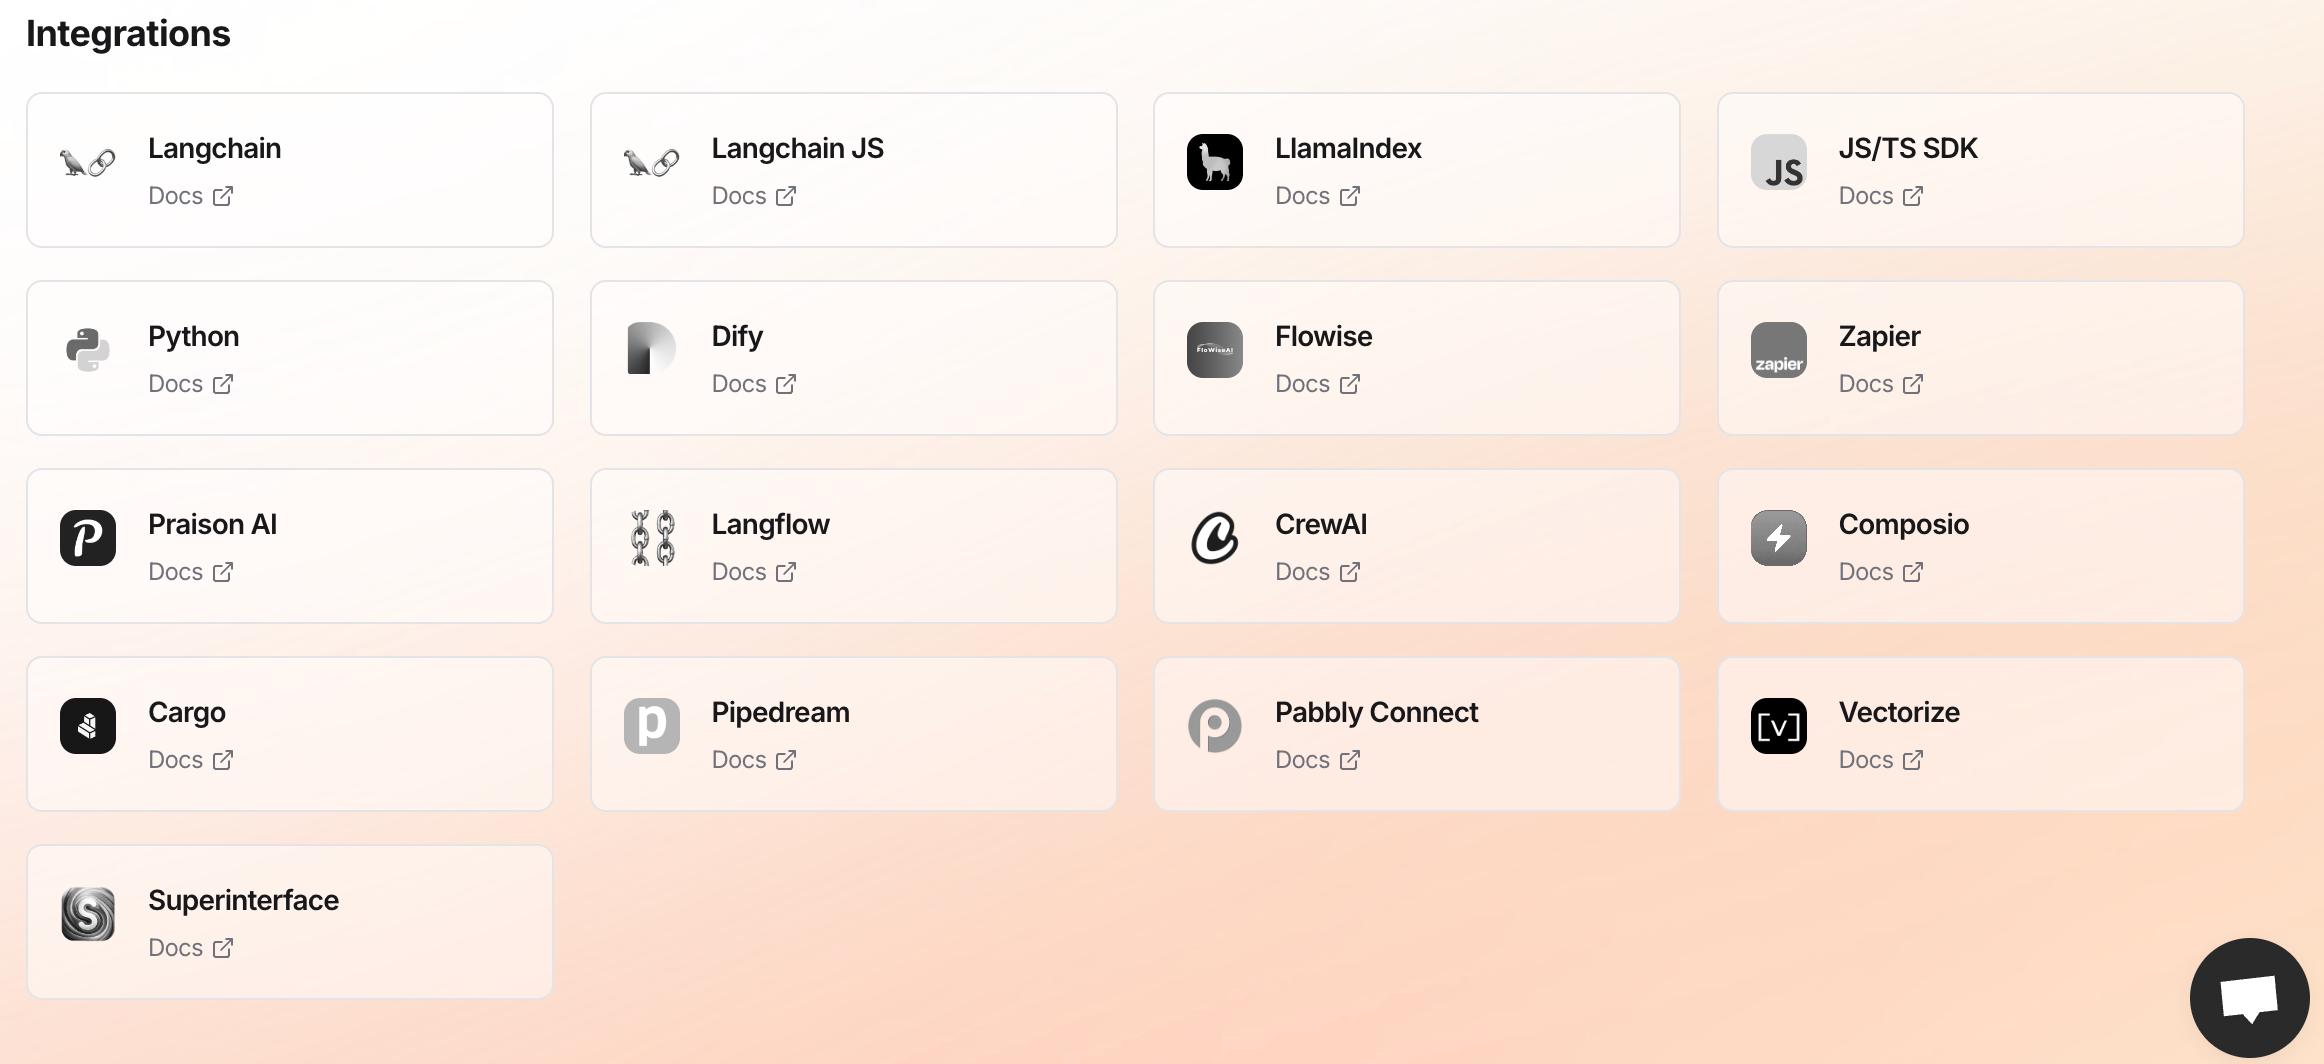

In this section, we will see how to use the LangChain integration to build a basic QA chatbot on the [LangChain Community Integrations](https://python.langchain.com/docs/integrations/providers/) website.

Start by installing LangChain and its related libraries:

```bash
$ pip install langchain langchain_community langchain_anthropic langchain_openai
```

Then, add your `ANTHROPIC_API_KEY` and `OPENAI_API_KEY` as  variables to your `.env` file. 

Next, import the `SpideryLoader` class from the document loaders module and initialize it:

In [25]:
from dotenv import load_dotenv
from langchain_community.document_loaders.spidery import SpideryLoader

load_dotenv()

loader = SpideryLoader(
    url="https://python.langchain.com/docs/integrations/providers/",
    mode="crawl",
    params={"limit": 5, "scrapeOptions": {"onlyMainContent": True}},
)

The class can read your Spidery API key automatically since we are loading the variables using `load_dotenv()`.

To start the crawl, you can call the `load()` method of the loader object and the scraped contents will be turned into LangChain compatible documents:

In [ ]:
# Start the crawl
docs = loader.load()

The next step is chunking:

In [26]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Add text splitting before creating the vector store
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

# Split the documents
split_docs = text_splitter.split_documents(docs)

Above, we split the documents into smaller chunks using the `RecursiveCharacterTextSplitter`. This helps make the text more manageable for processing and ensures better results when creating embeddings and performing retrieval. The chunk size of 1000 characters with 100 character overlap provides a good balance between context preservation and granularity.

In [33]:
from langchain_chroma import Chroma
from langchain.embeddings import OpenAIEmbeddings
from langchain_community.vectorstores.utils import filter_complex_metadata

# Create embeddings for the documents
embeddings = OpenAIEmbeddings()

# Create a vector store from the loaded documents
docs = filter_complex_metadata(docs)
vector_store = Chroma.from_documents(docs, embeddings)

Moving on, we created a vector store using Chroma and OpenAI embeddings. The vector store allows us to perform semantic search and retrieval on our documents. We also filter out any complex metadata that might cause issues during storage.

The final step is building the QA chain where we use Claude 3.5 Sonnet as the language model:

In [34]:
from langchain.chains import RetrievalQA
from langchain_anthropic import ChatAnthropic

# Initialize the language model
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620", streaming=True)

# Create a QA chain
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=vector_store.as_retriever(),
)

Now, we can ask questions about our documents:

In [35]:
# Example question
query = "What is the main topic of the website?"
answer = qa_chain.invoke(query)

print(answer)

{'query': 'What is the main topic of the website?', 'result': "The main topic of the website is LangChain's integrations with Hugging Face. The page provides an overview of various LangChain components that can be used with Hugging Face models and services, including:\n\n1. Chat models\n2. LLMs (Language Models)\n3. Embedding models\n4. Document loaders\n5. Tools\n\nThe page focuses on showing how to use different Hugging Face functionalities within the LangChain framework, such as embedding models, language models, datasets, and other tools."}


This section demonstrated a rough process for building a basic RAG pipeline for content scraped using Spidery. For this version, we only used 10 pages from the LangChain documentation and as the information increases, the pipeline would need more work. To scale this pipeline, we would need to consider factors like chunking strategy, embedding model selection, vector store optimization, and prompt engineering to handle larger document collections effectively.

## Conclusion

Throughout this guide, we've explored Spidery's `/crawl` endpoint and its capabilities for web scraping at scale. From basic usage to advanced configurations, we covered URL control, performance optimization, and asynchronous operations. We also examined practical implementations including data storage solutions and integration with frameworks like LangChain.

The endpoint's ability to handle JavaScript content, pagination, and various output formats makes it a versatile tool for modern web scraping needs. Whether building documentation chatbots or gathering training data, Spidery provides a robust foundation. By leveraging the configuration options and best practices discussed, you can build efficient and scalable web scraping solutions tailored to your specific requirements.